In [ ]:
!pip install tbats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 909.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

x = pd.read_csv('/content/drive/MyDrive/TataSteel10years.csv')
# x = pd.read_csv('TISC Historical Data.csv')

Mounted at /content/drive


In [ ]:
x['Vol.'] = x['Vol.'].str.replace('M', '').astype(float) * 1e6
x['Change %'] = x['Change %'].str.replace('%', '').astype(float)

reversed_x = x.iloc[::-1]

x_sorted = reversed_x.reset_index(drop=True)

reversed_x = x.iloc[::-1]

x_sorted = reversed_x.reset_index(drop=True)

x_sorted['Date'] = pd.to_datetime(x_sorted['Date'])

x_sorted['Price_diff'] = x_sorted['Price'].diff()
x_sorted['Price_diff'][0] = 0
x_sorted = x_sorted.drop(['Price','Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)

split = int(len(x_sorted)*0.7)
test = x_sorted[split:]
train = x_sorted[:split]

test = test.reset_index(drop=True)
train = train.reset_index(drop=True)


<ipython-input-4-15b1afc9ff32>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_sorted['Price_diff'][0] = 0


In [ ]:
from tbats import TBATS

# Fit the TBATS model
tbats_estimator = TBATS(seasonal_periods=(7, 30.5, 365.25))
tbats_model = tbats_estimator.fit(train['Price_diff'])
tbats_forecast = tbats_model.forecast(steps=7)
predicted_price_next_7_days_tbats = tbats_forecast

In [ ]:
# Time series analysis
print(tbats_model.summary())

print(tbats_model.y_hat) # in sample prediction
print(tbats_model.resid) # in sample residuals
print(tbats_model.aic)
# Reading model parameters
print(tbats_model.params.alpha)
print(tbats_model.params.beta)
print(tbats_model.params.x0)
print(tbats_model.params.components.use_box_cox)
print(tbats_model.params.components.seasonal_harmonics)

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: []
Seasonal harmonics []
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.013751
Seasonal Parameters (Gamma): []
AR coefficients []
MA coefficients []
Seed vector [-0.28236002]

AIC 13729.642359
[-0.28236002 -0.27847728 -0.28289855 ...  0.4269012   0.50353709
  0.5001882 ]
[ 0.28236002 -0.32152272 -0.31710145 ...  5.5730988  -0.24353709
  2.5698118 ]
13729.642359132135
0.013751037597656071
None
[-0.28236002]
False
[]


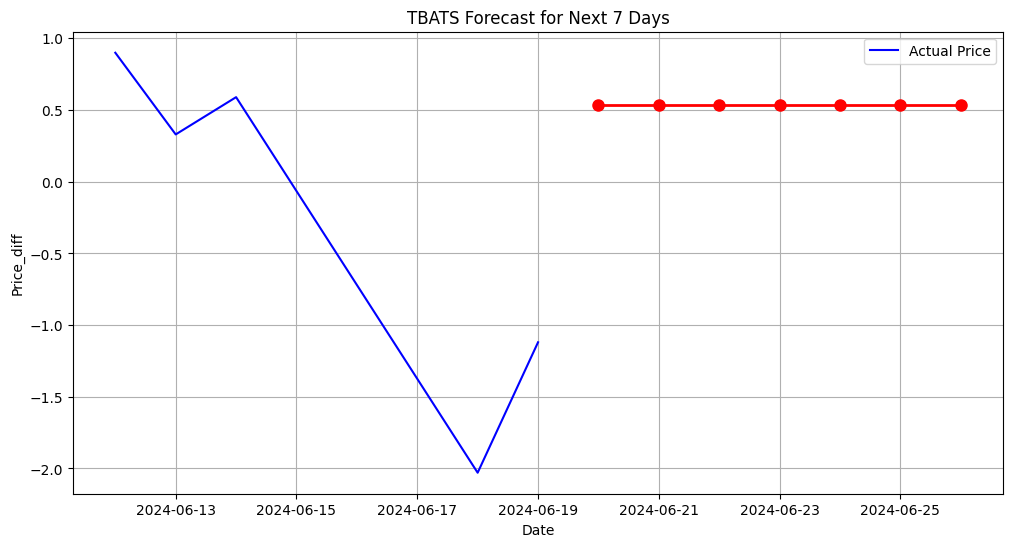

         Date  Forecasted Price
0  2024-06-20          0.535526
1  2024-06-21          0.535526
2  2024-06-22          0.535526
3  2024-06-23          0.535526
4  2024-06-24          0.535526
5  2024-06-25          0.535526
6  2024-06-26          0.535526


In [ ]:
# Create a date range for the forecast
last_date = pd.to_datetime(test['Date'].iloc[-1])
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7)

# Plot the forecasted prices
plt.figure(figsize=(12, 6))
plt.plot(forecast_index, predicted_price_next_7_days_tbats, color='red', marker='o', linestyle='-', linewidth=2, markersize=8, label='Forecasted Price')
plt.plot(test['Date'][-5:], test['Price_diff'][-5:], color='blue', label='Actual Price')
plt.title('TBATS Forecast for Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Price_diff')
plt.grid(True)
plt.legend()
plt.show()

# Create a DataFrame with the forecasted prices
forecast_df_tbats = pd.DataFrame({'Date': forecast_index.date, 'Forecasted Price': predicted_price_next_7_days_tbats})
print(forecast_df_tbats)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
actual_stock_price = test.iloc[:,1:2].values

def print_metrics(model_name, actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted)
    mda = median_absolute_error(actual, predicted)
    directional_accuracy = np.mean(np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - actual[:-1])) * 100

    print(f"{model_name} Metrics:")
    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAPE:", mape)
    print("Median Absolute Error:", mda)
    print("Directional Accuracy:", directional_accuracy, "%")
    print()


print_metrics("TBATS", actual_stock_price[-7:], predicted_price_next_7_days_tbats)

TBATS Metrics:
MAE: 0.8863534597276465
MSE: 1.4979083316302055
RMSE: 1.2238906534614133
MAPE: 0.7088372538104953
Median Absolute Error: 0.5044742180935645
Directional Accuracy: 100.0 %

